# <font color=black> Analysis - FC-based parcellation using correlation </font>
<hr style="border:1px solid black">

In [1]:
import sys,json
import glob, os
import numpy as np
import nibabel as nib
import time
from nilearn import datasets, plotting, image, surface
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

sys.path.append('/media/miplab-nas2/Data3/BMPD/hc_project/analysis/code/')

from fc_based_parcellation import FC_Parcellation

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Initialization
<hr style="border:0.5px solid black">

### Load existing configuration file ...

In [65]:
# Load the config file with all information
filetag = "postcentral_to_C1toC7_gm_D"
with open('../../../brain_spine/results/fc_parcellation/corr/' + filetag + '/config_' + filetag + '.json') as config_file:
    config = json.load(config_file)
target = 'spinalcord'
source = 'brain'
config['brain_surfaces']='/templates/surf/'
# Instantiate class
# Note: this will save a config file with all relevant information and prepare folder structure
fc_parcellation = FC_Parcellation(config,source,target,'corr')

### ... or build new one

In [58]:
# Load the config file with all information
with open('../../config/config_fc_based_parcellation_NK.json') as config_file:
    config = json.load(config_file)
# Define tag of this analysis (used for saving)
config['output_tag'] = "C1toC7_gm_D_to_poscentral_nofilter"
# Define source, target, and the corresponding masks
target = 'brain'
source = 'spinalcord'
# Note: paths should be with respect to main directory
config['file_tag']['spinalcord'] = "_task-rest_bold_stc_sc_moco_brsc_nofilter_inTemplate_s.nii.gz"
config['file_tag']['brain'] = "_task-rest_bold_stc_brain_moco_brsc_nofilter_reg_SPM_inTemplate2mm_s.nii.gz"
config['masks']['source'] = "/analysis/masks/spinalcord/PAM50_C1C7_gm_D.nii.gz"
config['masks']['target'] = "/analysis/masks/brain/MNI_GM_2mm_postcentral.nii.gz"
config['template']['spinalcord'] = "/templates/PAM50_hc_project/template/PAM50_t2.nii.gz"
config['spinal_levels'] = "/templates/PAM50_hc_project/template/PAM50_spinal_levels_C1C7.nii.gz"
config['brain_surfaces']='/templates/surf/'

config['list_subjects'] = ["P030", "P099","A006","A007","A008","A009","A011","A013","A023","A024","A025","A026","A027","A028","A029","A030","A032","A033","A034","A036","A037","A038","A039","A043","A044","A045","A046","A048","A050","A051","A052"]

# Instantiate class
# Note: this will save a config file with all relevant information and prepare folder structure
fc_parcellation = FC_Parcellation(config,source,target,'corr')

# Analyses
<hr style="border:0.5px solid black">

### Compute the voxelwise correlation & run clustering for each subject independently

In [59]:
levels_vec.shape

(6128,)

In [34]:
import nibabel as nib

levels_img = nib.load('/media/miplab-nas2/Data3/BMPD/hc_project/templates/PAM50_hc_project/template/PAM50_spinal_levels_C1C7.nii.gz')
levels = levels_img.get_fdata()

mask_img = nib.load('/media/miplab-nas2/Data3/BMPD/hc_project/templates/PAM50_hc_project/template/PAM50_gm_bin07_C1C7.nii.gz')
mask = mask_img.get_fdata()
levels_masked = levels * mask
levels_vec = levels_masked.flatten()[levels_masked.flatten() > 0]


In [41]:
fc=np.zeros((31,9000,14343))
for sub_id,sub in enumerate(["P030", "P099","A006","A007","A008","A009","A011","A013","A023","A024","A025","A026","A027","A028","A029","A030","A032","A033","A034","A036","A037","A038","A039","A043","A044","A045","A046","A048","A050","A051","A052"]):
    fc[sub_id,:,:]=np.load('/media/miplab-nas2/Data3/BMPD/hc_project/brain_spine/results/fc_parcellation/corr/C1toC7_gm_07_to_iCAP_SMC/fcs/C1toC7_gm_07_to_iCAP_SMC_' + sub + '_corr.npy')

In [42]:
levels_vec = levels_vec.astype(int)
levels_sorted = np.argsort(levels_vec)

In [47]:
fc_mean = np.mean(fc,axis=0)

In [44]:
corr_all=np.zeros((31,9000,9000))
for sub_id,sub in enumerate(["P030", "P099","A006","A007","A008","A009","A011","A013","A023","A024","A025","A026","A027","A028","A029","A030","A032","A033","A034","A036","A037","A038","A039","A043","A044","A045","A046","A048","A050","A051","A052"]):
    corr_all[sub_id,:,:] = np.corrcoef(fc[sub_id,:,:])

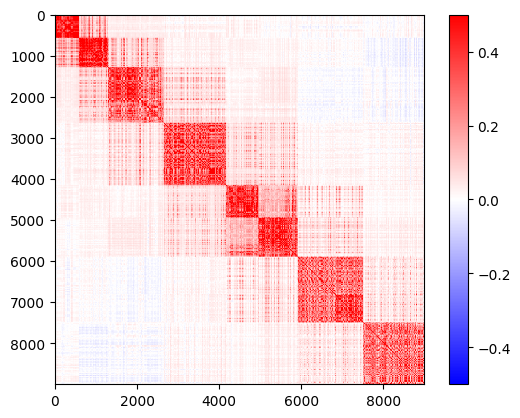

In [46]:
corr_mean = np.mean(corr_all,axis=0)
corr_mean_r = corr_mean[levels_sorted,:]
corr_mean_r = corr_mean_r[:,levels_sorted]
plt.imshow(corr_mean_r,cmap='bwr', vmin=-0.5, vmax=0.5)
plt.colorbar()

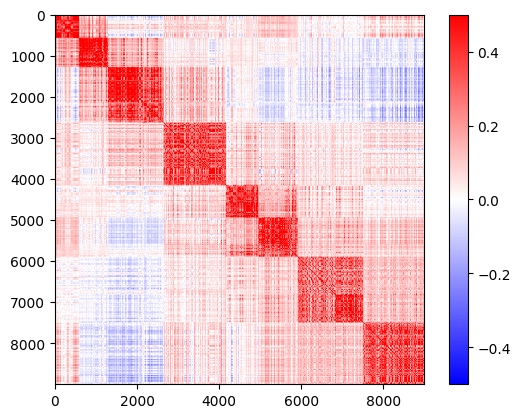

In [48]:
# Calculate the correlation matrix
corrmat = np.corrcoef(fc_mean)
corrmat_r = corrmat[levels_sorted,:]
corrmat_r = corrmat_r[:,levels_sorted]
plt.imshow(corrmat_r,cmap='bwr', vmin=-0.5, vmax=0.5)
plt.colorbar()

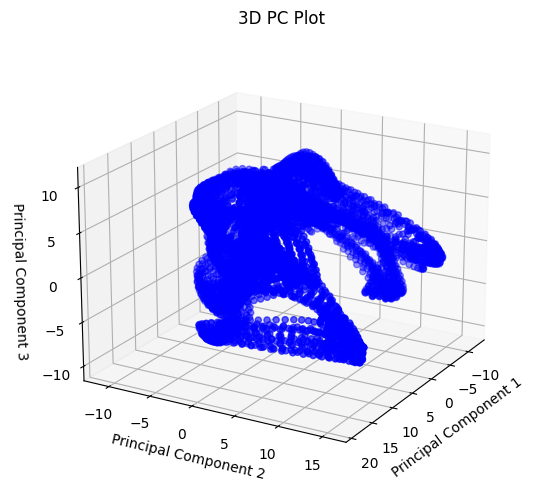

In [14]:
from sklearn.decomposition import PCA
from scipy.stats import zscore

pca = PCA(n_components=3)
pca_result = pca.fit_transform(corrmat_r)

# Create a 3D PC plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2], c='b', marker='o')

# Set axis labels
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Set plot title
ax.set_title('3D PC Plot')
# Enable 3D rotation tool
ax.view_init(elev=20, azim=30)  # Set the initial view

# Show the plot
plt.show()

In [59]:
start = time.time()
# Loop through the subjects to compute fc and clustering 
for sub_id,sub in enumerate(fc_parcellation.config['list_subjects']): 
    print(f'\033[1mSUBJECT {sub}\033[0m')
    # Compute correlation without saving files
    fc_parcellation.compute_voxelwise_fc(sub=sub, 
                                        overwrite=False)
    # Run clustering and save labels
    fc_parcellation.run_clustering(sub=sub,
                                    k_range=7,algorithm='spectral',
                                    overwrite=False)
print("\033[1m... Operation performed in %.2f s!\033[0m" % (time.time() - start))

SUBJECT P030
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... Loading data
... Computing FC for all possibilities
... Metric: correlation
... Fisher transforming correlations

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = spectral
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running spectral clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(




SUBJECT P099
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... Loading data
... Computing FC for all possibilities
... Metric: correlation
... Fisher transforming correlations

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = spectral
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running spectral clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(




SUBJECT A006
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... Loading data
... Computing FC for all possibilities
... Metric: correlation
... Fisher transforming correlations

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = spectral
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running spectral clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(




SUBJECT A007
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... Loading data
... Computing FC for all possibilities
... Metric: correlation
... Fisher transforming correlations

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = spectral
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running spectral clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(




SUBJECT A008
COMPUTE VOXELWISE FC
Standardize = True
Overwrite results = False
... Loading data
... Computing FC for all possibilities
... Metric: correlation
... Fisher transforming correlations

DONE
CLUSTERING AT THE INDIVIDUAL LEVEL
Algorithm = spectral
K value(s) = 7
Overwrite results = False
K = 7
... Loading FC from file
... Running spectral clustering


/home/kinany/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


KeyboardInterrupt: 

### Compute the group-level clustering and generate corresponding maps

In [ ]:
fc_parcellation.group_clustering(k_range=7,indiv_algorithm='spectral',overwrite=False)

In [ ]:
fc_parcellation.prepare_target_maps(label_type='indiv',indiv_algorithm='spectral',k_range=7,overwrite=False)

In [ ]:
fc_parcellation.prepare_target_maps(label_type='group_mode',indiv_algorithm='spectral',k_range=7,overwrite=False)

### Statistics and WTA analysis

In [51]:
fc_parcellation.stats_target_maps(label_type='indiv',indiv_algorithm='spectral',k_range=8,overwrite=False)

RUN STATISTICAL ANALYSIS
Type of source labels = indiv
K value(s) = 8
Overwrite results = False
K = 8
... Merging target files
fslmerge -t /media/miplab-nas2/Data3/BMPD/hc_project//brain_spine/results/fc_parcellation//corr/postcentral_to_C1toC7_gm_D_nofilter/target//K8/indiv_labels/maps_indiv/postcentral_to_C1toC7_gm_D_nofilter_all_spectral_indiv_labels_targetmap_K8_1.nii.gz /media/miplab-nas2/Data3/BMPD/hc_project//brain_spine/results/fc_parcellation//corr/postcentral_to_C1toC7_gm_D_nofilter/target//K8/indiv_labels/maps_indiv/postcentral_to_C1toC7_gm_D_nofilter_*_spectral_indiv_labels_targetmap_K8_1.nii.gz
... Running statistical analysis
randomise options: -i /media/miplab-nas2/Data3/BMPD/hc_project//brain_spine/results/fc_parcellation//corr/postcentral_to_C1toC7_gm_D_nofilter/target//K8/indiv_labels/maps_indiv/postcentral_to_C1toC7_gm_D_nofilter_all_spectral_indiv_labels_targetmap_K8_1.nii.gz -m /media/miplab-nas2/Data3/BMPD/hc_project//analysis/masks/spinalcord/PAM50_C1C7_gm_D.nii.

... Running statistical analysis
randomise options: -i /media/miplab-nas2/Data3/BMPD/hc_project//brain_spine/results/fc_parcellation//corr/postcentral_to_C1toC7_gm_D_nofilter/target//K8/indiv_labels/maps_indiv/postcentral_to_C1toC7_gm_D_nofilter_all_spectral_indiv_labels_targetmap_K8_7.nii.gz -m /media/miplab-nas2/Data3/BMPD/hc_project//analysis/masks/spinalcord/PAM50_C1C7_gm_D.nii.gz -o /media/miplab-nas2/Data3/BMPD/hc_project//brain_spine/results/fc_parcellation//corr/postcentral_to_C1toC7_gm_D_nofilter/target//K8/indiv_labels/stats/spectral/K8_7 -1 
Loading Data: 
Data loaded
One-sample design detected; sign-flipping instead of permuting.
2.14748e+09 sign-flips required for exhaustive test of t-test 1
Doing 5000 random permutations
Warning! No output options selected. Outputing raw tstat only
Starting permutation 1 (Unpermuted data)
Finished, exiting.
... Merging target files
fslmerge -t /media/miplab-nas2/Data3/BMPD/hc_project//brain_spine/results/fc_parcellation//corr/postcentral_

In [52]:
fc_parcellation.winner_takes_all(label_type='indiv',indiv_algorithm='spectral',apply_threshold=1,k=8, overwrite=True)

RUN WINNER-TAKES-ALL ANALYSIS
Type of source labels = indiv
K value = 8
Overwrite results = True
K1 will have a value of 1
K2 will have a value of 2
K3 will have a value of 3
K4 will have a value of 4
K5 will have a value of 5
K6 will have a value of 6
K7 will have a value of 7
K8 will have a value of 8


/home/kinany/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:493: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


DONE



/home/kinany/anaconda3/lib/python3.9/site-packages/nilearn/masking.py:974: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


# Plotting
<hr style="border:0.5px solid black">

### WTA maps

RUN PLOTTING BRAIN MAPS
K value = 8
Showing = source
Save figure = True
Source labels are not re-ordered!


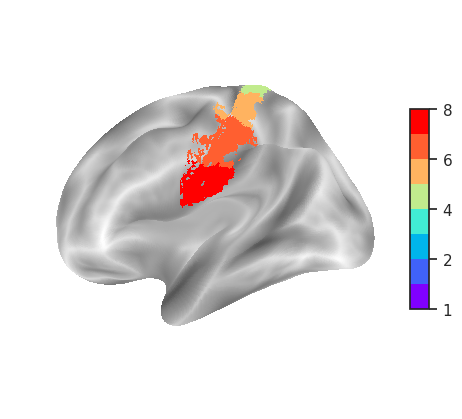

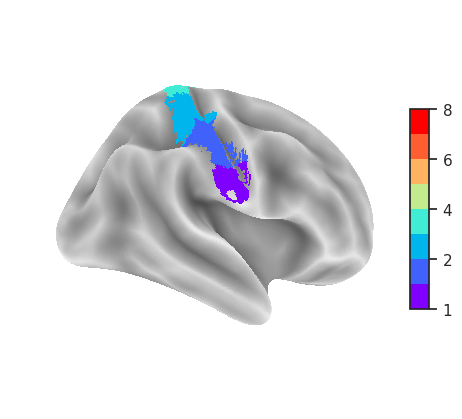

In [53]:
fc_parcellation.plot_brain_map(showing='source',indiv_algorithm='spectral', k=8, save_figure=True)

### Plot label maps

RUN PLOTTING SPINAL MAPS
K value = 8
Showing = target
Save figure = True
The plotting is displayed in neurological orientation (Left > Right)


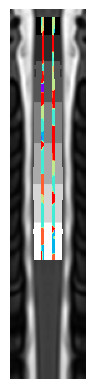

In [55]:
fc_parcellation.plot_spinal_map(showing='target',label_type='indiv',k=8, slice_y=24,indiv_algorithm='spectral', save_figure=True)

### Validity
<hr style="border:0.5px solid black">

### Plot validity metrics

VALIDITY METRICS
K value(s) = range(2, 10)
Saving figures = True



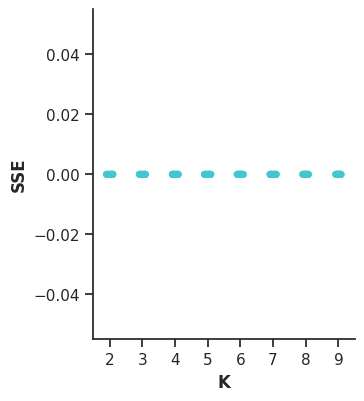

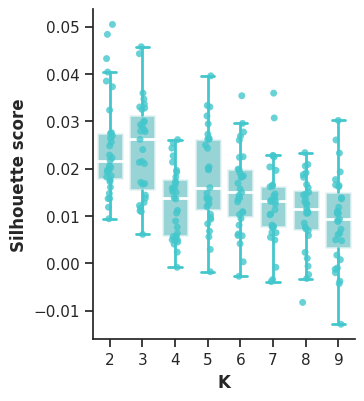

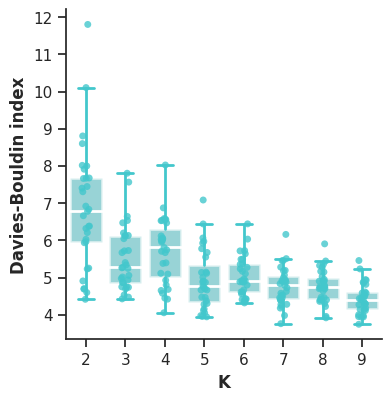

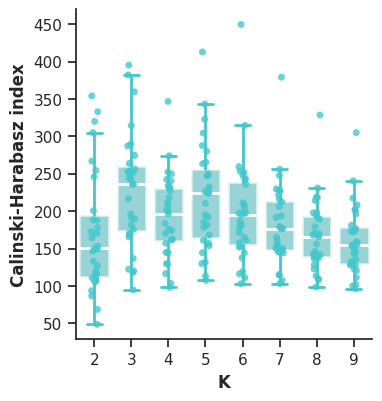

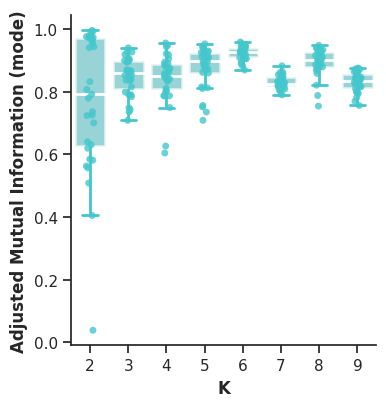

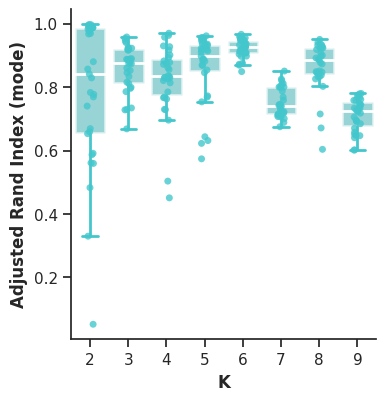

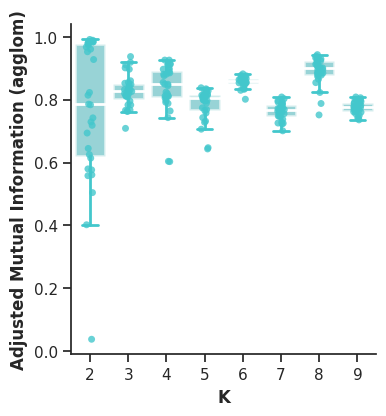

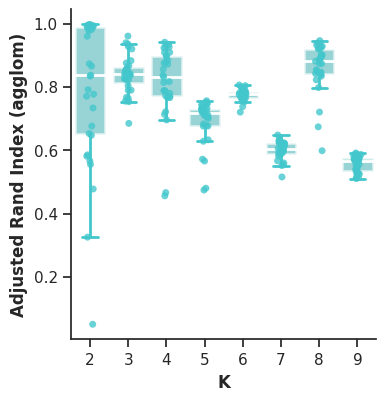

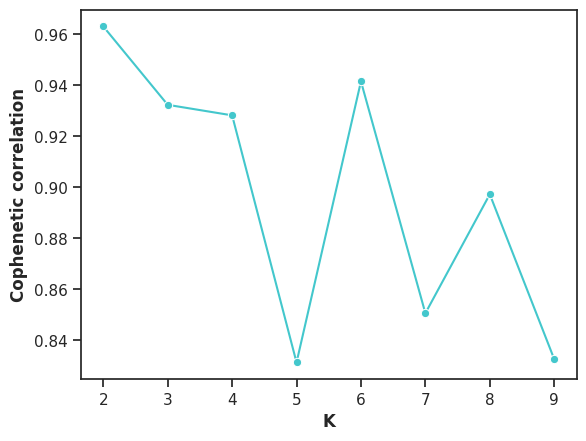

In [44]:
fc_parcellation.plot_validity(k_range=range(2,10),indiv_algorithm='spectral',internal=["SSE", "silhouette", "davies", "calinski"], group=["ami_mode", "ari_mode","ami_agglom", "ari_agglom", "corr"], save_figures=True)